In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import transformations as t
from mpl_toolkits.mplot3d import Axes3D
import os

tf.logging.set_verbosity(tf.logging.INFO)

def show_cv2(img):
    # swap b and r channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])

    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()

def plot_histogram(img):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()
    
def add_grayscale_noise(img, std_dev):
    noise = np.expand_dims(np.random.normal(0, std_dev, size=img.shape[:2]).astype(np.int8), axis=2)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return img

def add_colored_noise(img, std_dev):
    noise = np.random.normal(0, std_dev, size=img.shape).astype(np.int8)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return img


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def listfiles(path):
    return [os.path.join(dp, f) for dp, dn, fn in os.walk(path) for f in fn]
tag_urls = listfiles("./tags")
scene_urls = listfiles("./places")

print(tag_urls[0], scene_urls[0])

./tags/tag36_11_00376.png ./places/Places365_val_00001162.jpg


In [3]:
# Populate some camera intrinsic settings
# And other constants
# To do: capitolize these variables names idk how to find and replace in this notebook

camera_intrinsics = [1.1998640834468974e+03, 0, 640.0 / 2, 0, 1.1998640834468974e+03, 480.0 / 2, 0, 0, 1]
camera_intrinsics = np.array(camera_intrinsics).reshape([3, 3])

fx = camera_intrinsics[0,0]
fy = camera_intrinsics[1,1]
cx = camera_intrinsics[0,2]
cy = camera_intrinsics[1,2]

tag_size = 0.01

print(camera_intrinsics)

[[1.19986408e+03 0.00000000e+00 3.20000000e+02]
 [0.00000000e+00 1.19986408e+03 2.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [40]:
def gen_sample(noise_background=False, plot=False):
    if noise_background:
        img_scene = np.random.randint(0, 255, size=(480, 640, 3)).astype(np.uint8)
    else:
        img_scene = cv2.resize(cv2.imread(np.random.choice(scene_urls)), (640, 480), interpolation=cv2.INTER_AREA)

    img_tag = cv2.resize(cv2.imread(np.random.choice(tag_urls)), (200, 200), interpolation=cv2.INTER_NEAREST)

    world_corners = np.array([[-1, -1], [1, -1], [-1, 1], [1, 1]]) * tag_size / 2.0
    pixel_corners = np.array([[0, 0], [1, 0], [0, 1], [1, 1]]) * np.array(img_tag.shape)[:2]

    # Add a Z component and homogeneous coordinate
    corners_3d = np.hstack((world_corners, np.array([[0, 1]] * 4)))

    done = False
    attempts = 0
    while not done:
        # Apply a random rotation to our corners
        angle_lim = np.pi / 2.5
        rotation_matrix = t.rotation_matrix(np.random.uniform(-angle_lim, angle_lim), [1, 0, 0])
        rotation_matrix = rotation_matrix @ t.rotation_matrix(np.random.uniform(-angle_lim, angle_lim), [0, 1, 0])
        rotation_matrix = rotation_matrix @ t.rotation_matrix(np.random.uniform(-np.pi, np.pi), [0, 0, 1])
        corners_3d_rotated = (rotation_matrix @ corners_3d.T).T

        # Translate our corners to a random 3D point within our camera view
        z = np.random.triangular(0.05, 0.05, 0.2)
        x = np.random.uniform(-1, 1) * z / fx * cx
        y = np.random.uniform(-1, 1) * z / fy * cy
        translation = np.array([x, y, z])
        translation_matrix = t.translation_matrix(translation)
        corners_3d_transformed = (translation_matrix @ corners_3d_rotated.T).T

        # Project into 2D image space
        projected_transformed = camera_intrinsics @ corners_3d_transformed.T[:3]
        projected_transformed /= projected_transformed[2]

        # Flip y and x to match OpenCV
        projected_transformed = np.vstack((projected_transformed[1], projected_transformed[0]))
        # print(projected_transformed)

        done = True
        attempts += 1
        for (x, y) in projected_transformed.T:
            # Reject views that have tag corners chopped off
            if x < 0 or y < 0 or x > cx * 2 or y > cy * 2:
                done = False

    # print(attempts, "attempt(s)")

    # Compute a homography
    H = cv2.findHomography(pixel_corners, projected_transformed.T)[0]

    # Random lighting condition
    dynamic_range = np.random.uniform(0.9, 1.0)
    img_tag_lighting = img_tag * dynamic_range
    img_tag_lighting += (1.0 - dynamic_range) * np.random.uniform(0, 255)
    img_tag_lighting = img_tag_lighting.astype(np.uint8)
    
    # Some noise
    img_tag_filtered = cv2.GaussianBlur(img_tag_lighting, (9, 9), 0)
    img_tag_filtered = add_colored_noise(img_tag_filtered, 4)
    img_tag_filtered = add_grayscale_noise(img_tag_filtered, 10)
    
    # Overlay warped image
    img_scene_with_tag = np.array(img_scene)
    cv2.warpPerspective(img_tag_filtered, H, dsize=img_scene.shape[:2][::-1], dst=img_scene_with_tag, borderMode=cv2.BORDER_TRANSPARENT)
    img_scene_with_tag = cv2.GaussianBlur(img_scene_with_tag, (3, 3), 0)
    img_scene = cv2.GaussianBlur(img_scene, (3, 3), 0)

    # Bias our tag's color towards the image average color
    img_tag_filtered = (img_tag_filtered * 49.0 / 50.0 + (np.mean(img_scene,axis=(0,1)) / 50.0).astype(np.int16)).astype(np.uint8)

    # Plot?
    if plot:
        show_cv2(img_tag_filtered)
        
        # Visualize in 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xs = corners_3d.T[0]
        ys = corners_3d.T[1]
        zs = corners_3d.T[2]
        ax.scatter(xs, ys, zs)

        xs = corners_3d_transformed.T[0]
        ys = corners_3d_transformed.T[1]
        zs = corners_3d_transformed.T[2]
        ax.scatter(xs, ys, zs)

        # Visualize in 3D
        plt.figure()
        plt.ylim(0, cy * 2)
        plt.xlim(0, cx * 2)

        #xs = projected_orig[0]
        #ys = projected_orig[1]
        #plt.scatter(xs, ys)
        xs = projected_transformed[0]
        ys = projected_transformed[1]
        plt.plot(xs, ys)

        plt.show()
        
        # Visualize the scene + histograms
        plot_histogram(img_scene)
        show_cv2(img_scene)

        plot_histogram(img_scene_with_tag)
        show_cv2(img_scene_with_tag)
        
    return img_scene, img_scene_with_tag

# gen_sample(False, True)
# pass

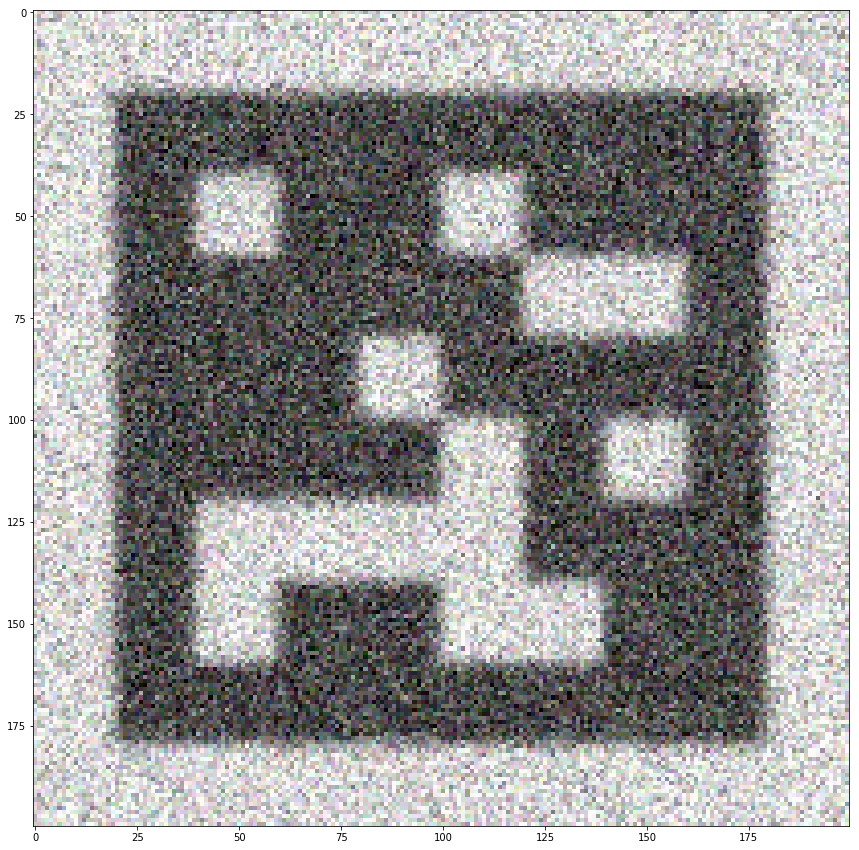

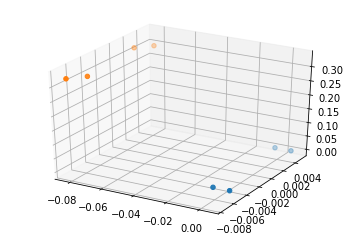

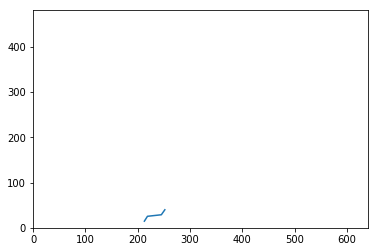

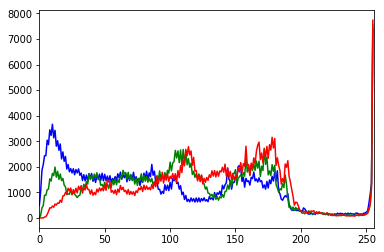

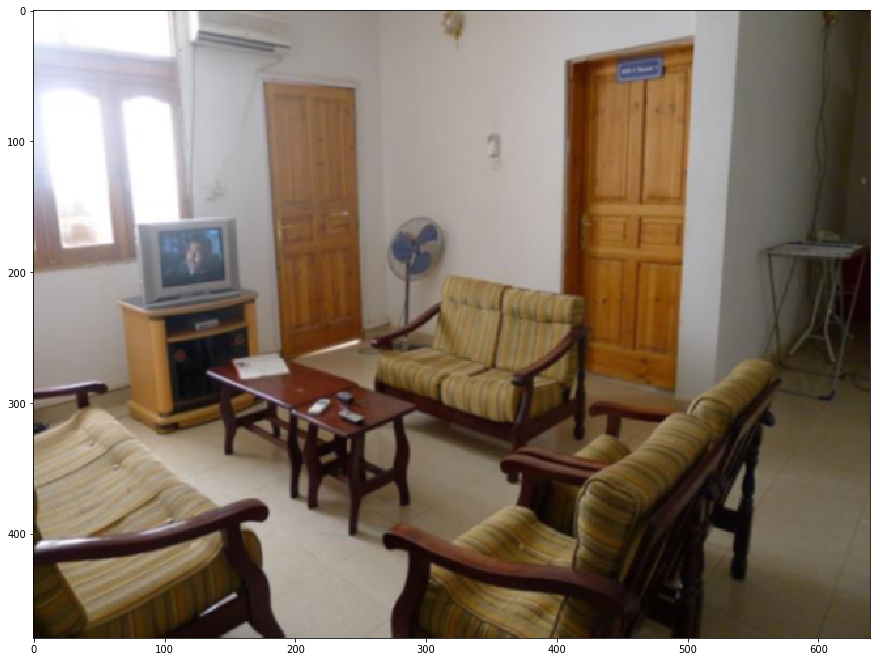

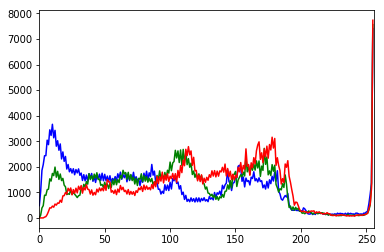

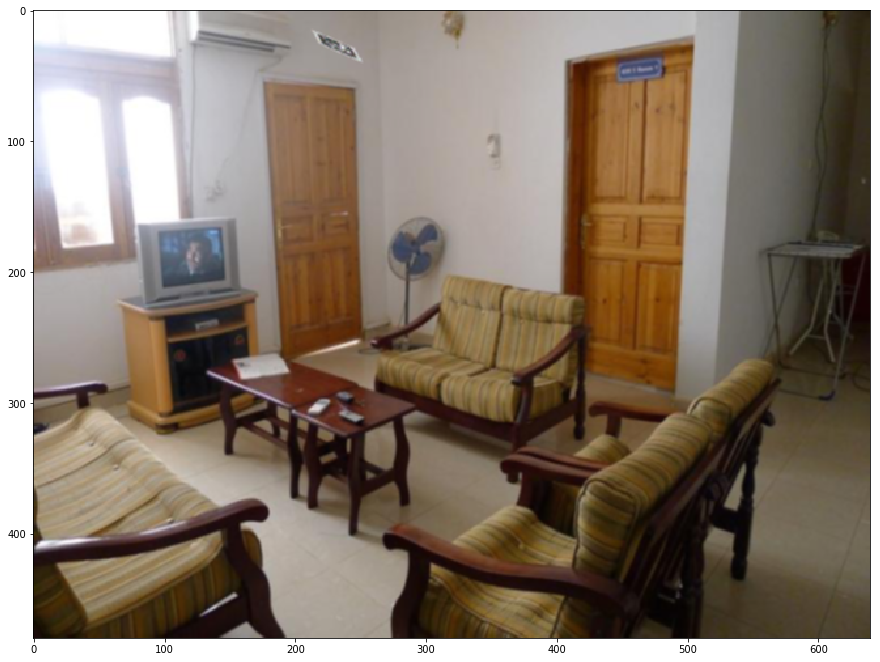

In [38]:
# Test for generating training sample

gen_sample(False, True)
pass

In [41]:
global global_scene

# Helper for generating training/validation batches

def gen_samples(n, noise_scene=False, plot=False, include_neg=True):
    images = []
    labels = []
    for _ in range(n):
        neg, pos = gen_sample(noise_scene, plot)
        
        global global_scene
        global_scene = pos

        neg = neg.astype(np.float32)
        pos = pos.astype(np.float32)
        neg /= 255.0
        neg -= 0.5
        pos /= 255.0
        pos -= 0.5

        if include_neg:
            images.append(neg)
            labels.append(0)
        images.append(pos)
        labels.append(1)
        
    return np.asarray(images), np.asarray(labels).astype(np.float32)

In [44]:
def cnn_model_fn(features, labels, mode):

    """Model function for CNN."""
    # Input Layer
    
    #######################################################33
    # TODO: fill in size
    size = [480, 640]
    
    input_layer = tf.image.resize_images(
                            features["x"],
                            size,
                            method=tf.image.ResizeMethod.BILINEAR,
                            align_corners=False)

    ### TODO: make these stride size smaller when we have more than 2 hours to train this model
    print("features", features["x"].shape)
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.leaky_relu)
    print("conv1", conv1.shape)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 4], strides=4)

    print("pool1", pool1.shape)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.leaky_relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[4, 4], strides=4)

    # Convolutional Layer #3 and Pooling Layer #3
    conv3 = tf.layers.conv2d(
      inputs=conv2,
      filters=16,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.leaky_relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[8, 8], strides=8)
    
    print("pool3", pool3.shape)
    # Dense Layer
    
    #######################################################33
    # TODO fill in some_size
    flattened_conv = tf.reshape(pool3, [-1, 20 * 15 * 16])
    print("flattened_conv", flattened_conv.shape)
    dense = tf.layers.dense(inputs=flattened_conv, units=1024, activation=tf.nn.leaky_relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    # creates the 1 output: does this image have a tag in it?
    logits = tf.squeeze(tf.layers.dense(inputs=dropout, units=1), axis=1)
    
    # Compute a probability w/ a sigmoid
    prob = tf.sigmoid(logits, name="prob_tensor")

    labels = tf.add(labels, tf.constant(0.0), name="label_tensor")
    print("logits",logits.shape, flush=True)
    print("prob",prob.shape, flush=True)
    print("labels",labels.shape, flush=True)

    predictions = {
      "predictions": tf.round(prob),
      "probabilities": prob
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return prob

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.nn.l2_loss(labels - prob, name="loss")

    # Add a margin to the loss
    #loss = tf.maximum(tf.constant(0.0), loss - 0.0004)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    
    # Saliency
    
    accuracy = tf.metrics.accuracy(
          labels=labels, predictions=predictions["predictions"], name="accuracy")
    
    saliency_grad = tf.gradients(prob, input_layer, name="saliency_grad")
    saliency_map = tf.squeeze(tf.reduce_max(tf.abs(saliency_grad), axis=4), name="saliency_map")

    eval_metric_ops = {"accuracy": accuracy}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [45]:
global global_saliency_map

class SaliencyHook(tf.train.SessionRunHook):

  def __init__(self):
    return

  def begin(self):
    # Convert names to tensors
    #self._current_tensors = {tag: _as_graph_element(tensor)
    #                         for (tag, tensor) in self._tensors.items()}
    #self._saliency_map = [_as_graph_element("loss")]

    print("testtests")

  def before_run(self, run_context):
    return tf.train.SessionRunArgs({
        "saliency_map": _as_graph_element("saliency_map", run_context.session.graph)
    })

  def after_run(self, run_context, run_values):
    m = run_values.results["saliency_map"]
    m += np.min(m)
    m /= np.max(m)

    global global_saliency_map
    global_saliency_map = m

#     print("HELLO")
# #     session = run_context.session
#     values = session.run(_as_graph_element("loss", session.graph))
#     print("here")
#     print(values)

def _as_graph_element(obj, graph):
  """Retrieves Graph element."""
  import six
  if not isinstance(obj, six.string_types):
    if not hasattr(obj, "graph") or obj.graph != graph:
      raise ValueError("Passed %s should have graph attribute that is equal "
                       "to current graph %s." % (obj, graph))
    return obj
  if ":" in obj:
    element = graph.as_graph_element(obj)
  else:
    element = graph.as_graph_element(obj + ":0")
    # Check that there is no :1 (e.g. it's single output).
    try:
      graph.as_graph_element(obj + ":1")
    except (KeyError, ValueError):
      pass
    else:
      raise ValueError("Name %s is ambiguous, "
                       "as this `Operation` has multiple outputs "
                       "(at least 2)." % obj)
  return element

In [46]:
print("Building estimator...", flush=True)
# Create the Estimator
classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="./model")

def train():
    #######################################################
    # TODO NEED TO FIX THE ENTIRE FUNCTION

    # Set up logging for predictions
    tensors_to_log = {"loss": "loss", "prob": "prob_tensor", "labels": "label_tensor"}
    logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=100)

    print("Training model...", flush=True)
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)

    classifier.train(
      input_fn=train_input_fn,
      steps=4,
      hooks=[logging_hook])
# train()

def eval():
    print("Evaluating model...", flush=True)
    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    saliency_hook = SaliencyHook()
    eval_results = classifier.evaluate(input_fn=eval_input_fn, hooks=[saliency_hook])
    print(eval_results)


Building estimator...
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_task_type': 'worker', '_num_worker_replicas': 1, '_evaluation_master': '', '_task_id': 0, '_model_dir': './model', '_save_summary_steps': 100, '_global_id_in_cluster': 0, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f44f994b390>, '_session_config': None, '_master': '', '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': None, '_service': None}


In [161]:
for i in range(20):
    train_data, train_labels = gen_samples(50, False)
    train()

Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3801 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.], loss = 0.09937187, prob = [0.05959407 0.02443902 0.26258016 0.02053101 0.02040452 0.99943334
 0.11054995 0.7160419  0.0329024  0.99999905 0.02615112 0.99999857
 0.999977   0.01751936 0.04212533 0.9929913  0.11709232 0.999987
 0.0200392  0.11809231]
INFO:tensorflow:step = 3800, loss = 0.09937187
INFO:tensorflow:Saving checkpoints for 3804 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.015354342.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3804
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3805 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.], loss = 0.47856882, prob = [0.05211174 0.99670756 0.99972683 0.99968743 0.02981514 0.03631144
 0.9976311  0.9492578  0.03550395 0.02071834 0.04473465 0.9998246
 0.07526842 0.03539402 0.99999714 0.91709435 0.02781962 0.99999595
 0.9648627  0.9798329 ]
INFO:tensorflow:step = 3804, loss = 0.47856882
INFO:tensorflow:Saving checkpoints for 3808 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.47306487.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3808
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3809 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1.], loss = 0.0069959913, prob = [0.01631688 0.9999887  0.04265645 0.03238474 0.03288927 0.02226797
 0.9738548  0.9996197  0.9824311  0.02489516 0.02795151 0.99086237
 0.03091338 0.98399633 0.02492614 0.9713038  0.05538975 0.9694318
 0.99942565 0.9880171 ]
INFO:tensorflow:step = 3808, loss = 0.0069959913
INFO:tensorflow:Saving checkpoints for 3812 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.011559246.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3812
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3813 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.], loss = 0.010171139, prob = [0.02916264 0.99993813 0.01885981 0.03954932 0.96988285 0.9996082
 0.9999924  0.99998343 0.03089765 0.0474624  0.09555849 0.03003946
 0.01063682 0.9661065  0.03524666 0.02021036 0.99988174 0.9943305
 0.02188101 0.99996126]
INFO:tensorflow:step = 3812, loss = 0.010171139
INFO:tensorflow:Saving checkpoints for 3816 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.90229195.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3816
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3817 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.], loss = 0.43423563, prob = [0.04636356 0.9290553  0.9998821  0.9997638  0.99993014 0.9999988
 0.99997795 0.99998677 0.99970144 0.9999927  0.02312866 0.9969029
 1.         0.03212073 1.         0.9999989  0.999964   0.9996675
 0.9983724  0.03998518]
INFO:tensorflow:step = 3816, loss = 0.43423563
INFO:tensorflow:Saving checkpoints for 3820 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 1.407436.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3820
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3821 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], loss = 0.2870279, prob = [0.01776118 0.03512345 0.99998677 0.9999995  0.03640714 0.996644
 0.9354519  0.0204991  0.04163252 0.9999999  0.03060422 0.03314027
 0.02802417 0.01592904 0.034355   0.25230327 0.9932894  0.02318283
 0.99995303 0.03102967]
INFO:tensorflow:step = 3820, loss = 0.2870279
INFO:tensorflow:Saving checkpoints for 3824 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.09216009.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3824
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3825 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.], loss = 0.04835576, prob = [0.17220803 0.99743134 0.03920699 0.06406286 0.9999968  0.9999999
 0.0290699  0.06199861 0.08690536 0.99999964 0.21573973 0.9999838
 0.04585292 0.97776836 0.999959   0.9999995  0.9997087  0.9948837
 0.9999348  0.9998704 ]
INFO:tensorflow:step = 3824, loss = 0.04835576
INFO:tensorflow:Saving checkpoints for 3828 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.6182114.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3828
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3829 into ./model/model.ckpt.
INFO:tensorflow:labels = [1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1.], loss = 0.14885324, prob = [0.9998093  0.99983954 0.9198957  0.028282   0.01905883 0.8994759
 0.09979226 0.9996625  0.99999475 0.49050874 0.9959961  0.02845875
 0.0593238  0.95597064 0.01712229 0.99974436 0.9999782  0.03942253
 0.03326842 0.85778147]
INFO:tensorflow:step = 3828, loss = 0.14885324
INFO:tensorflow:Saving checkpoints for 3832 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.10104006.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3832
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3833 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0.], loss = 0.020908412, prob = [0.02323351 0.999114   0.03150794 0.00526401 0.025939   0.9879638
 0.00750443 0.02424115 0.11107972 0.01664183 0.99989116 0.9881788
 0.06198613 0.998774   0.9974637  0.0275481  0.96497715 0.01989757
 0.13678099 0.03313698]
INFO:tensorflow:step = 3832, loss = 0.020908412
INFO:tensorflow:Saving checkpoints for 3836 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.99463224.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3836
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3837 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.], loss = 0.030167218, prob = [0.01025137 0.04231859 0.971789   0.04938279 0.0256251  0.99998
 0.02699513 0.9999571  0.19523542 0.06981219 0.01009327 0.03841603
 0.99997556 0.9998344  0.03829179 0.04938891 0.07035557 0.99995923
 0.01987055 0.9999691 ]
INFO:tensorflow:step = 3836, loss = 0.030167218
INFO:tensorflow:Saving checkpoints for 3840 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.13132305.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3840
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3841 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.], loss = 0.019333035, prob = [0.03087766 0.07630664 0.02889728 0.99967027 0.9726123  0.05810918
 0.04650883 0.99991274 0.9997379  0.9989999  0.05740671 0.03498427
 0.03108757 0.09975187 0.04418673 0.06387867 0.99749845 0.04124799
 0.99755484 0.03976153]
INFO:tensorflow:step = 3840, loss = 0.019333035
INFO:tensorflow:Saving checkpoints for 3844 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.13381372.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3844
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3845 into ./model/model.ckpt.
INFO:tensorflow:labels = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.], loss = 0.10367278, prob = [0.9999523  0.99943346 0.57463247 0.9998852  0.99912137 0.98243594
 0.99985504 0.99332434 0.99947053 0.9998647  0.02872859 0.04573819
 0.9997762  0.8598362  0.9891262  0.0386272  0.9981193  0.9999386
 0.02396482 0.03608486]
INFO:tensorflow:step = 3844, loss = 0.10367278
INFO:tensorflow:Saving checkpoints for 3848 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.026280122.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3848
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3849 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.], loss = 0.012410337, prob = [0.02258804 0.99704427 0.9999732  0.05438234 0.05019824 0.9994265
 0.04419734 0.9999827  0.9985935  0.08135328 0.9991779  0.9990403
 0.07409877 0.9994815  0.02613078 0.99994934 0.04135469 0.9999589
 0.0437474  0.9787635 ]
INFO:tensorflow:step = 3848, loss = 0.012410337
INFO:tensorflow:Saving checkpoints for 3852 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.54286253.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3852
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3853 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1.], loss = 1.1487571, prob = [0.1103023  0.99991906 0.96350557 0.9993568  0.03272612 0.08601516
 0.93415374 0.9997002  0.0189474  0.02592915 0.03098256 0.99997973
 0.04738507 0.9999031  0.04236765 0.9990778  0.01813326 0.6131429
 0.99665195 0.01924417]
INFO:tensorflow:step = 3852, loss = 1.1487571
INFO:tensorflow:Saving checkpoints for 3856 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.79638445.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3856
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3857 into ./model/model.ckpt.
INFO:tensorflow:labels = [1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.], loss = 0.94762844, prob = [0.9915131  0.9408678  0.06610107 0.01600726 0.01946254 0.0049149
 0.02214993 0.9995555  0.00722533 0.04317731 0.99989486 0.02299557
 0.06916571 0.9815833  0.02210056 0.02731376 0.9324226  0.02217572
 0.05366867 0.98845357]
INFO:tensorflow:step = 3856, loss = 0.94762844
INFO:tensorflow:Saving checkpoints for 3860 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.08893519.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3860
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3861 into ./model/model.ckpt.
INFO:tensorflow:labels = [1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.], loss = 0.03431582, prob = [0.9993106  0.99995065 0.99999464 0.04391413 0.9430923  0.04226993
 0.04221533 0.9999231  0.07708787 0.9993795  0.99988484 0.2018596
 0.9999896  0.02305606 0.05557269 0.02275691 0.99994636 0.07767243
 0.05508458 0.99998903]
INFO:tensorflow:step = 3860, loss = 0.03431582
INFO:tensorflow:Saving checkpoints for 3864 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.48663977.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3864
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3865 into ./model/model.ckpt.
INFO:tensorflow:labels = [1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.], loss = 0.034419313, prob = [0.9907925  0.9994747  0.9999912  0.03581085 0.99975365 0.89276356
 0.8092276  0.01307626 0.00653562 0.8853229  0.02809987 0.01320628
 0.02834043 0.9996209  0.02869122 0.9999747  0.01660659 0.03923695
 0.9795793  0.037282  ]
INFO:tensorflow:step = 3864, loss = 0.034419313
INFO:tensorflow:Saving checkpoints for 3868 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.013317124.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3868
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3869 into ./model/model.ckpt.
INFO:tensorflow:labels = [1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1.], loss = 0.0135954805, prob = [0.9990495  0.03756642 0.01251655 0.99914145 0.9996112  0.97755253
 0.03218447 0.9971008  0.9991968  0.9993793  0.9915944  0.06059504
 0.99993825 0.99991393 0.9920202  0.01383885 0.99775106 0.05058566
 0.86837333 0.9864006 ]
INFO:tensorflow:step = 3868, loss = 0.0135954805
INFO:tensorflow:Saving checkpoints for 3872 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.053010788.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3872
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3873 into ./model/model.ckpt.
INFO:tensorflow:labels = [0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0.], loss = 0.14870581, prob = [0.04378859 0.02513683 0.9960467  0.06023053 0.9920432  0.00958025
 0.99998474 0.4684851  0.99998164 0.9526109  0.9999052  0.03567681
 0.03025988 0.99404234 0.9910483  0.99995065 0.03325894 0.03795305
 0.99999535 0.03820122]
INFO:tensorflow:step = 3872, loss = 0.14870581
INFO:tensorflow:Saving checkpoints for 3876 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.6877299.


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 480, 640, 32)
pool1 (20, 120, 160, 32)
pool3 (20, 15, 20, 16)
flattened_conv (20, 4800)
logits (20,)
prob (20,)
labels (20,)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3876
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3877 into ./model/model.ckpt.
INFO:tensorflow:labels = [1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.], loss = 0.015231738, prob = [0.99678504 0.03368642 0.9612595  0.03098681 0.03806537 0.07357249
 0.9996984  0.03101976 0.02046649 0.9968485  0.04341703 0.08045769
 0.9847377  0.9391479  0.9992403  0.04408916 0.9847974  0.02993854
 0.04841877 0.02989492]
INFO:tensorflow:step = 3876, loss = 0.015231738
INFO:tensorflow:Saving checkpoints for 3880 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.012717282.


Evaluating model...
INFO:tensorflow:Calling model_fn.
features (?, 480, 640, 3)
conv1 (?, 480, 640, 32)
pool1 (?, 120, 160, 32)
pool3 (?, 15, 20, 16)
flattened_conv (?, 4800)
logits (?,)
prob (?,)
labels (?,)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-19:20:17
testtests
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3880
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-19:20:18
INFO:tensorflow:Saving dict for global step 3880: accuracy = 1.0, global_step = 3880, loss = 2.3085533e-09
{'loss': 2.3085533e-09, 'accuracy': 1.0, 'global_step': 3880}
[331. 108.]
[385. 142.]
[358 125]


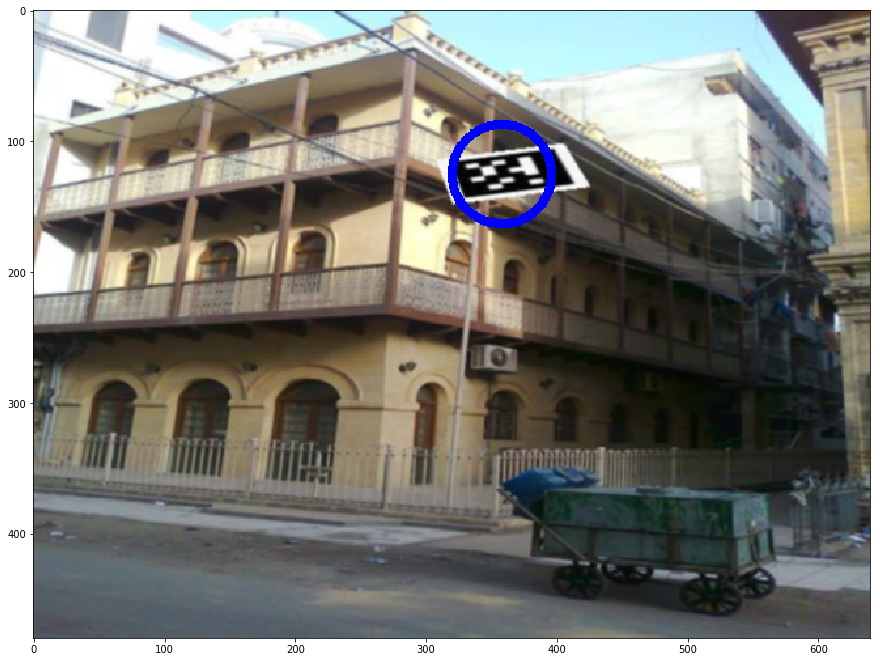

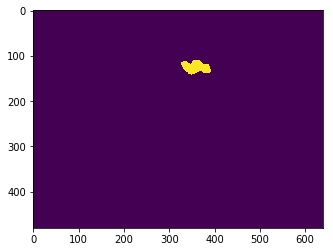

In [74]:
eval_data, eval_labels = gen_samples(1, False, plot=False, include_neg=False)
eval()

global global_scene
global global_saliency_map


smap_filtered = cv2.GaussianBlur(global_saliency_map, (19, 19), 0)
smap_clipped = np.clip(np.round(smap_filtered + 0.4), 0, 1)
smap_bool = smap_clipped > 0.5

coords = []
for y in range(smap_clipped.shape[0]):
    for x in range(smap_clipped.shape[1]):
        if smap_bool[y][x]:
            coords.append([x, y])
coords = np.array(coords).astype(np.float)

if len(coords) == 0:
    # this is rare
    raise Exception("try again oops")

std_dev = np.linalg.norm(np.std(coords, axis=0))
m = np.median(coords,axis=0)

new_coords = []
for pair in coords:
    if np.linalg.norm(pair - m) < std_dev * 1.5:
        new_coords.append(pair)

coords = np.asarray(new_coords)

center_min = np.min(coords, axis=0)
center_max = np.max(coords, axis=0)
center = ((center_min + center_max) / 2.0).astype(np.int)
size = (np.linalg.norm(center_max - center_min) / 2 * 1.2).astype(np.int)
print(center_min)
print(center_max)
print(center)
marked_scene = np.array(global_scene)
# marked_scene[center] = [0, 255, 0]
#cv2.circle(marked_scene, center, 63, (0,0,255))

cv2.circle(marked_scene, tuple(center), size, (255, 0, 0), 5)
show_cv2(marked_scene)

plt.figure()
plt.imshow(smap_clipped)
plt.show()

# Create a black image
img = np.zeros((512,512,3), np.uint8)

# Draw a diagonal blue line with thickness of 5 px


In [ ]:
# do some traditional cv stuff to located corners from our region proposal
# and compute world->tag transform with that